In [1]:
%reload_ext autoreload
%autoreload 2
import os, sys
if 'notebook_path' not in vars():
    notebook_path = os.getcwd()
os.chdir(os.path.join(notebook_path,"../.."))
sys.path.append(os.getcwd())


import numpy as np
import matplotlib.pyplot as plt

import torch, h5py#, tikzplotlib

from src.DatasetTDE import DatasetTDE
import configs.config_train as config_train
import configs.config_eval as config_eval


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

from models.gcc_phat.gcc_phat import gcc_phat

models = config_eval.get_models()

In [3]:
from src.DatasetTdoa20201016 import DatasetTdoa20201016
d = DatasetTdoa20201016()
dl = torch.utils.data.DataLoader(d, batch_size=config_train.batch_size)


In [4]:
residuals = {}
for model_name in models:
    print(model_name)
    model = models[model_name]
    reses = []
    with torch.no_grad():
        for batch,(X,y) in enumerate(dl):
            X = X.to(device)
            pred = model(X).cpu()
            pred = pred.argmax(1) - 500
            res = pred - y
            reses.append(res)
        residuals[model_name] = torch.concatenate(reses).numpy()


SONNET
GCC-PHAT


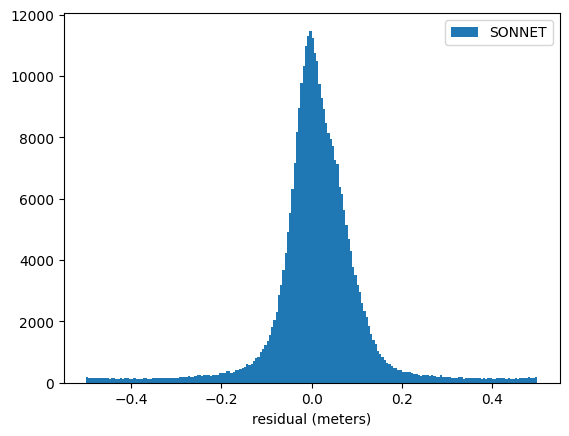

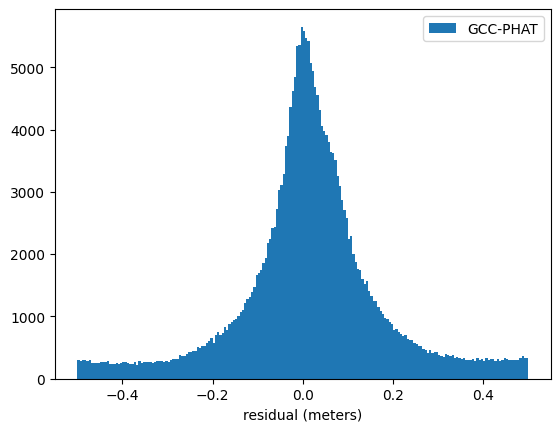

In [5]:
for model_name in models.keys():
    res = residuals[model_name]
    plt.figure()
    plt.hist(res/50,200,range=(-0.5,0.5));
    plt.legend([model_name])
    plt.xlabel("residual (meters)")


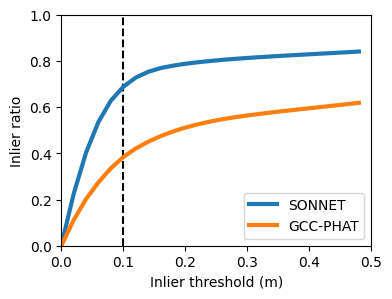

In [6]:
xs = np.arange(25)
plt.figure(figsize=(4,3))
plt.axvline(0.1,linestyle='--', color='k',label='_nolegend_')
for res in residuals.values():
    c_acc = [sum(np.abs(res) < i)/res.shape[0] for i in xs]
    plt.plot(xs/50, c_acc, linewidth=3)

plt.legend(models.keys())
plt.xlabel('Inlier threshold (m)')
plt.ylabel('Inlier ratio')

plt.ylim(0,1)
plt.xlim(0,0.5)

#tikzplotlib.save("real_cumulative.tex")


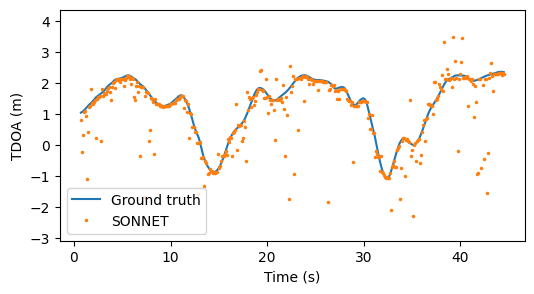

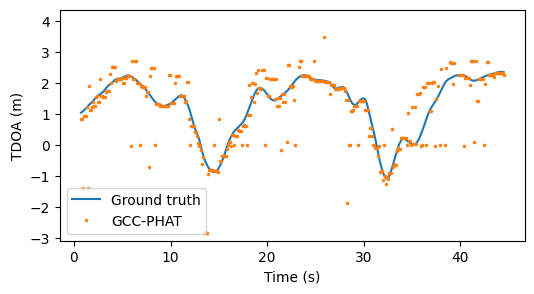

In [32]:
experiment = "music_0014"
experiment = "chirp_0001"
mics = [0,5]
sound, tdoa, times = d.get_sequence(experiment, mics)

for model_name in models:
    plt.figure(figsize=(6,3))
    plt.plot(times,tdoa/50,'-')
    with torch.no_grad():
        pred = models[model_name](torch.tensor(sound).to(device)).argmax(1).cpu().numpy() - 500
    plt.plot(times, pred/50, '.',markersize=3)
    plt.ylabel('TDOA (m)')
    plt.xlabel("Time (s)")
    #plt.title(experiment + " mics: "+ str(mics))
    plt.legend(["Ground truth",model_name],bbox_to_anchor=(0,0), loc="lower left")
    plt.ylim(np.min(tdoa)/50-2,np.max(tdoa)/50 + 2)
    #tikzplotlib.save(model_name + "_on_" + experiment + ".tex")
